STRATEGY : find stocks having the ratio (marketcap / revenue) < 0.25 THEN we pass each stock to a ML model that will tell us to buy or not.
expected 1y return : 15 -17 %


In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import random
import requests
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from dotenv import load_dotenv
import os

In [2]:
load_dotenv() 
fmp_api_key = os.getenv("API_KEY")
def get_stock_price(ticker,date):
    try:
      stock = yf.Ticker(ticker)
      date_str = date.strftime('%Y-%m-%d')
      hist_data = stock.history(start=date, end=date + timedelta(days=1))
      if date_str in hist_data.index:
          price_on__date = hist_data.loc[date_str]['Close']
          return price_on__date
      else:
          #print(f"No trading data available for {stock} on {date_str}")
          return None
    except Exception as e:
        # If any exception occurs, return None
        return None

def get_today_market_cap(symbol,api_key):

  url = f"https://financialmodelingprep.com/api/v3/market-capitalization/{symbol}"
  params = {
        "apikey": api_key
    }
  response = requests.get(url,params)
  if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")
  data = response.json()
  return data[0]['marketCap']

def get_today_market_cap8TEST(symbol,api_key):

  return 6000000000;

def get_fmp_market_cap(symbol, start_date, end_date, api_key):
    url = f"https://financialmodelingprep.com/api/v3/historical-market-capitalization/{symbol}"
    params = {
        "from": start_date.strftime("%Y-%m-%d"),
        "to": end_date.strftime("%Y-%m-%d"),
        "apikey": api_key
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")
    data = response.json()

    market_caps = {datetime.strptime(item['date'], "%Y-%m-%d").date(): item['marketCap'] for item in data}
    return pd.Series(market_caps)

# print(get_stock_price("NKE", datetime.strptime("2024-08-24", "%Y-%m-%d")))
# print(get_stock_price("NKE", datetime.strptime("2024-08-25", "%Y-%m-%d")))
# print(get_stock_price("NKE", datetime.strptime("2024-08-26", "%Y-%m-%d")))
# print(get_stock_price("NKE", datetime.strptime("2024-08-27", "%Y-%m-%d")))
# print(get_stock_price("NKE", datetime.strptime("2024-08-28", "%Y-%m-%d")))
def get_revenues(stock_symbol):
    ticker = yf.Ticker(stock_symbol)
    financials = ticker.financials

    if 'Total Revenue' in financials.index:
        revenue = financials.loc['Total Revenue']
        return revenue
    else:
        return None

def get_OtherExpenses(stock_symbol):
    ticker = yf.Ticker(stock_symbol)
    financials = ticker.financials

    if 'Net Non Operating Interest Income Expense' in financials.index:
        revenue = financials.loc['Net Non Operating Interest Income Expense']
        return revenue
    else:
        return None

def get_closest_market_cap(market_cap_series, target_date):
    if market_cap_series.empty:
          return None

    if isinstance(target_date, pd.Timestamp):
        target_date = target_date.date()

    if target_date in market_cap_series.index:
        return market_cap_series[target_date]

    # Find the closest available date
    closest_date = min(market_cap_series.index, key=lambda x: abs(x - target_date))

    # If the closest date is more than 5 days away, return None
    if abs((closest_date - target_date).days) > 5:
        return None

    return market_cap_series[closest_date]

def get_date_x_weeks_before(date_string, num_weeks_before):
    if isinstance(date_string, pd.Timestamp):
        date_string = date_string.strftime("%Y-%m-%d")

    date_object = dt.datetime.strptime(date_string, "%Y-%m-%d")
    new_date = date_object - dt.timedelta(weeks=num_weeks_before)
    new_date_string = new_date.strftime("%Y-%m-%d")
    return new_date_string

def calculate_weekly_moving_average_old(stock, random_date, num_periods=50):

    start_date = get_date_x_weeks_before(random_date, int(num_periods*1.3)) #to not having missing points
    stock_data = yf.download(stock, start=start_date, end=random_date)
    weekly_data = stock_data['Close'].resample('W').mean()

    weekly_data_sma = weekly_data.rolling(window=num_periods).mean()

    closest_date = pd.to_datetime(random_date)
    while closest_date not in weekly_data_sma.index and closest_date > weekly_data_sma.index[0]:
        closest_date -= dt.timedelta(days=1)
    sma_value = weekly_data_sma.loc[closest_date]


    return sma_value, weekly_data_sma

def calculate_daily_moving_average(stock, random_date, num_periods=10):
    start_date = random_date - pd.DateOffset(days=20)
    end_date = random_date + pd.DateOffset(days=1)
    # Calculate start date to ensure enough data
    #start_date = random_date - dt.timedelta(days=int(num_periods*1.3))
    hist_weeks = yf.download(stock, start=start_date.strftime('%Y-%m-%d'), end=end_date, interval='1d')

    if hist_weeks.empty:
        return None, None

    hist_weeks = hist_weeks.copy()
    # Calculate 10 days SMA
    hist_weeks['SMA_10d'] = hist_weeks['Close'].rolling(window=10, min_periods=1).mean()

    # Filter data from the start date
    min_date = random_date - dt.timedelta(weeks=num_periods)
    hist_weeks = hist_weeks.loc[hist_weeks.index >= min_date]

    # Round SMA values to integers
    hist_weeks['SMA_10d'] = hist_weeks['SMA_10d'].round().astype(int)

    # Get the SMA value for the random date
    closest_date = pd.to_datetime(random_date)

    while closest_date not in hist_weeks.index and closest_date > hist_weeks.index[0]:
        closest_date -= dt.timedelta(days=1)

    sma_value = hist_weeks.loc[closest_date, 'SMA_10d'] if closest_date in hist_weeks.index else None

    return sma_value, hist_weeks['SMA_10d']


def calculate_weekly_moving_average(stock, random_date, num_periods=50):

    # Calculate start date to ensure enough data
    #start_date = random_date - dt.timedelta(weeks=int(num_periods*1.3))
    start_date = random_date - pd.DateOffset(weeks=60)
    end_date = random_date + pd.DateOffset(weeks=1)
    hist_weeks = yf.download(stock, start=start_date.strftime('%Y-%m-%d'), end=end_date, interval='1wk')

    if hist_weeks.empty:
        return None, None
    hist_weeks = hist_weeks.copy()
    # Calculate 50-week SMA
    hist_weeks['SMA_50'] = hist_weeks['Close'].rolling(window=50, min_periods=1).mean()

    # Filter data from the start date
    min_date = random_date - dt.timedelta(weeks=num_periods)
    hist_weeks = hist_weeks.loc[hist_weeks.index >= min_date]

    # Round SMA values to integers
    hist_weeks['SMA_50'] = hist_weeks['SMA_50'].round().astype(int)

    # Get the SMA value for the random date
    closest_date = pd.to_datetime(random_date)

    while closest_date not in hist_weeks.index and closest_date > hist_weeks.index[0]:
        closest_date -= dt.timedelta(days=1)

    sma_value = hist_weeks.loc[closest_date, 'SMA_50'] if closest_date in hist_weeks.index else None

    return sma_value, hist_weeks['SMA_50']

def find_closest_previous_date(target_date, available_dates):
    target_date = pd.to_datetime(target_date)
    available_dates = pd.to_datetime(available_dates)
    previous_dates = available_dates[available_dates <= target_date]
    if not previous_dates.empty:
        return previous_dates.max()
    return None

import pickle
with open('xgboost_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open('scaler.pkl', 'rb') as scaler_file:
    loaded_scaler = pickle.load(scaler_file)

def predict_buy(date, symbol, price, ratio, SMA_50, SMA_10d, other_expense):
    # Create a DataFrame with a single row
    data = pd.DataFrame({
        'date': [date],
        'symbol': [symbol],
        'price': [price],
        'ratio': [ratio],
        'SMA_50': [SMA_50],
        'SMA_10d': [SMA_10d],
        'other_expense': [other_expense]
    })

    # Convert date to datetime if it's not already
    data['date'] = pd.to_datetime(data['date'])

    if price is None or SMA_50 is None or other_expense is None or SMA_10d is None:
        return None, None
    # # Handle potential missing values
    # data = data.fillna(0)  # or use another appropriate method to handle NaNs

    # Select only the numeric columns for scaling
    numeric_columns = ['price', 'SMA_50', 'SMA_10d','other_expense', 'ratio']
    X = data[numeric_columns]

    # Scale the features
    X_scaled = loaded_scaler.transform(X)

    # Make prediction
    prediction = loaded_model.predict(X_scaled)
    #probability = loaded_model.predict_proba(X_scaled)[0, 1]  # Probability of class 1 (buy)
    probability=1
    return prediction[0], probability

def get_recent_other_expenses(other_expenses_dict, stock, random_date):
    other_expenses = other_expenses_dict[stock]
    recent_other_exp_date = None
    recent_other_exp_value = None

    if other_expenses is not None:
        if not isinstance(other_expenses.index, pd.DatetimeIndex):
            other_expenses.index = pd.to_datetime(other_expenses.index)

        other_expenses = other_expenses.sort_index(ascending=True)
        # Convert random_date to Timestamp if it's a datetime.date
        if isinstance(random_date, pd.Timestamp):
            random_date_ts = random_date
        else:
            random_date_ts = pd.Timestamp(random_date)

        recent_other_expenses = other_expenses.loc[:random_date_ts]

        if not recent_other_expenses.empty:
            recent_other_exp_date = recent_other_expenses.index[-1]  # Get the last date from the index

            if recent_other_exp_date is not None and recent_other_exp_date >= random_date_ts - pd.Timedelta(days=365):
                recent_other_exp_value = recent_other_expenses.iloc[-1]
        else:
            # Handle the case where `recent_other_expenses` is empty
            recent_other_exp_date = None
            recent_other_exp_value = None

    if recent_other_exp_value is None:
      return None, None
    return recent_other_exp_date, recent_other_exp_value/100

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:03:08] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


strategy : in year Y, after revenue publication buy a stock having low (marketCap/revenue_year_Y)  and it wil increase after exaclty 1 year


BACKTESTING - SIMULATION

In [4]:
stocks_df = pd.read_csv('sp_500_stocks.csv')
stocks = stocks_df['Ticker'].tolist()
stocks = random.sample(stocks, 246)
data_5yr = yf.download(stocks, period="5y")

gain_list = []
today = pd.Timestamp.today()
historical_market_cap_startdate = today - timedelta(days=364*5)
hist_start_date_weekSMA = historical_market_cap_startdate - pd.DateOffset(weeks=60)
historical_market_cap_enddate = today - timedelta(days=100)
market_cap_dict = {}
revenues_dict = {}
other_expenses_dict = {}
hist_weekly_dict = {}
for stock in stocks:
    revenues = get_revenues(stock)
    hist_weekly_dict[stock] = yf.download(stock, start=hist_start_date_weekSMA, end=today, interval='1wk')
    revenues_dict[stock]=revenues
    otherexp = get_OtherExpenses(stock)
    other_expenses_dict[stock]=otherexp
    historical_market_cap = get_fmp_market_cap(stock, historical_market_cap_startdate, historical_market_cap_enddate, fmp_api_key)
    #market_cap_dict[stock] = historical_market_cap.to_dict()
    market_cap_dict[stock] = historical_market_cap  # This is a pandas Series

[*********************100%***********************]  243 of 244 completed
ERROR:yfinance:
21 Failed downloads:
[*********************100%***********************]  243 of 244 completedERROR:yfinance:['DISCK', 'DISH', 'BLL', 'FRC', 'FLIR', 'RE', 'WLTW', 'COG', 'NLOK', 'XLNX', 'CERN', 'ABC', 'ETFC', 'DISCA', 'PKI', 'ATVI', 'PBCT', 'WRK', 'BRK.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')
ERROR:yfinance:['SIVB']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d']")
ERROR:yfinance:['GEV']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**********************

In [5]:



INTITIAL_CAPTIAL = 1200
TRANSACITON_FEE = 2
RATIO_LOWER_BOUND = 0
RATIO_UPPER_BOUND = 0.25
NBR_OF_SIMULATION = 1500
SELL_LIMIT_PERCENTAGE = 30.8 # 30.8 sell a stock if it increase by SELL_LIMIT_PERCENTAGE

gain_list = []
data_list = []

for i in range(NBR_OF_SIMULATION):
  gain = 0
  #take a random date between today-5year and today-1year
  random_date = pd.Timestamp(today - pd.DateOffset(years=5)) + pd.to_timedelta(np.random.randint(0, (365*4 + 1)), unit='D')
  random_date = random_date.floor('D')
  while random_date.year == 2020:
    random_date = pd.Timestamp(today - pd.DateOffset(years=5)) + pd.to_timedelta(np.random.randint(0, (365*4 + 1)), unit='D')
    random_date = random_date.floor('D')
  if random_date.dayofweek in [5, 6]:  # 5 is Saturday, 6 is Sunday
    if random_date.dayofweek == 5:  # Saturday
        random_date -= pd.Timedelta(days=1)  # Move to Friday
    else:  # Sunday
        random_date += pd.Timedelta(days=1)  # Move to Monday
  #print("random date = ",random_date.date())
  date_after_1Y = random_date + pd.DateOffset(years=1)
  if i%100==0:
    print(f"Simulation {i+1}: {random_date.date()}")
  valid_stocks = []
  valid_stocks_prices = []
  #extract all stocks having ration in [RATIO_LOWER_BOUND,RATIO_UPPER_BOUND]
  for stock in stocks:
    revenues = revenues_dict[stock]
    if revenues is None:
      continue
    if not isinstance(revenues.index, pd.DatetimeIndex):
      revenues.index = pd.to_datetime(revenues.index)
    revenues = revenues.sort_index(ascending=True)
    #get most recent revenue before random_date
    #recent_revenue = revenues.loc[:random_date].iloc[-1] if not revenues.loc[:random_date].empty else None
    # get most recent revenue before random_date
    recent_revenues = revenues.loc[:random_date]
    recent_revenue_date = None
    recent_revenue_value = None
    if not recent_revenues.empty:
        recent_revenue_date = recent_revenues.index[-1]
        recent_revenue_value = recent_revenues.iloc[-1]
        if recent_revenue_date < random_date - timedelta(days=365):
            continue

    # Get market cap for the random date or the closest available date
    #market_cap = get_today_market_cap(stock,fmp_api_key)
    market_cap = get_closest_market_cap(market_cap_dict[stock], random_date)

    if recent_revenue_value is not None and market_cap is not None:
      ratio = market_cap/recent_revenue_value
      if RATIO_LOWER_BOUND <= ratio <= RATIO_UPPER_BOUND:
          price_at_rd_date = get_stock_price(stock, random_date)
          if price_at_rd_date is not None:
            valid_stocks.append((stock, price_at_rd_date,ratio))

  valid_stocks.sort(key=lambda x: x[1])
  #check if we can divide INTITIAL_CAPTIAL to buy stocks with equal weight
  end_of_loop=(len(valid_stocks)==0)
  last_index=0;
  if len(valid_stocks)<=0:
      continue
  budget_per_stock = INTITIAL_CAPTIAL/len(valid_stocks)

  while(end_of_loop==False and last_index<len(valid_stocks)):
      if(valid_stocks[last_index][1]>budget_per_stock):
          end_of_loop = True
      else:
        last_index+=1
  stocks_to_buy = valid_stocks[:last_index]
  #print("stocks to buy : ",stocks_to_buy)
  if len(stocks_to_buy)>0:

    #data_5yr = yf.download([stock for stock, _ in stocks_to_buy], period="5y")
    for stocks_to_buy in stocks_to_buy:
      buy = True
      stock = stocks_to_buy[0]
      initial_price = stocks_to_buy[1]
      quantity = int(budget_per_stock/initial_price)
      #get SMA_50 and other_expense
      SMA50Y,_=calculate_weekly_moving_average(stock, random_date, num_periods=50)
      SMA10D,_=calculate_daily_moving_average(stock, random_date, num_periods=10)

      recent_other_exp_date, recent_other_exp_value = get_recent_other_expenses(other_expenses_dict, stock, random_date)




      prediction, buy_probability = predict_buy(
          date=random_date,
          symbol=stock,
          price=initial_price,
          ratio=ratio,
          SMA_50=SMA50Y,
          SMA_10d=SMA10D,
          other_expense=recent_other_exp_value
      )
      if prediction ==0:
        buy=False

      if buy and stock in data_5yr['Close']:
          stock_data_5y = data_5yr['Close'][stock].tz_localize(None)

          max_price_within_one_year = stock_data_5y[random_date:date_after_1Y].max()

          last_price_after_1Y = stock_data_5y[random_date:date_after_1Y].iloc[-1]

          #last_price_after_1Y = subset_data.iloc[subset_data.index.get_loc(date_after_1Y, method='pad')]

          max_percentage_increase = (max_price_within_one_year - initial_price) / initial_price * 100
          gain_for_this_stock=0
          if max_percentage_increase >= SELL_LIMIT_PERCENTAGE:
            #print(f"  we bought {quantity} {stock} at {initial_price}$ and sell them at {(1+(SELL_LIMIT_PERCENTAGE/100))*initial_price}$")
            gain_for_this_stock= (SELL_LIMIT_PERCENTAGE/100)*initial_price*quantity - 2*TRANSACITON_FEE
          else:
            #print(f"  we bought {quantity} {stock} at {initial_price}$ and sell them at {last_price_after_1Y}$")
            gain_for_this_stock = (last_price_after_1Y - initial_price)*quantity - 2*TRANSACITON_FEE
              #if ((last_price_after_1Y - initial_price)*quantity - 2*TRANSACITON_FEE)<-30:
              # print(f"negative stock : {stock} price : {initial_price}")
          if gain_for_this_stock > INTITIAL_CAPTIAL*0.2:
            data_list.append({
                'date': random_date.date(),
                'symbol': stock,
                'price': initial_price,
                'ratio':stocks_to_buy[2],
                'to_buy': 1
            })
          elif gain_for_this_stock < -INTITIAL_CAPTIAL*0.03:
            data_list.append({
                'date': random_date.date(),
                'symbol': stock,
                'price': initial_price,
                'ratio':stocks_to_buy[2],
                'to_buy': 0
            })
          gain+=gain_for_this_stock
    if (gain!=0):
      gain_list.append(gain)

training_data = pd.DataFrame(data_list)
training_data['date'] = pd.to_datetime(training_data['date'])


print(training_data.head())
csv_filename = 'training_data.csv'
if NBR_OF_SIMULATION>100:
  training_data.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")


Simulation 1: 2023-05-01


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 101: 2021-08-20


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 201: 2021-02-11


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 301: 2023-02-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 401: 2021-04-16


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 501: 2021-03-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 601: 2021-09-27


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 701: 2023-03-24


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 801: 2022-06-02


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 901: 2022-08-16


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:$KR: possibly delisted; no price data found  (1d 2021-02-15 00:00:00 -> 2021-02-16 00:00:00)
[*********************100%***********************]  1 of 1 compl

Simulation 1001: 2021-09-22


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 1101: 2021-09-22


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 1201: 2021-02-09


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 1301: 2022-08-05


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Simulation 1401: 2021-02-05


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

        date symbol       price     ratio  to_buy
0 2021-08-27    MCK  197.183502  0.130096       1
1 2021-02-11     KR   30.966120  0.189564       1
2 2022-11-18    MCK  365.786285  0.195954       1
3 2022-01-20    MCK  248.011078  0.155611       1
4 2021-09-01    MCK  199.482971  0.131306       1
Data saved to training_data.csv


RESULT OF SIMULATION : GAIN PER MONTH AFTER ONE YEAR

length of gain list :  1206
[109.5928287  146.8102417  360.39511206 ... 187.43020251  22.94999695
  73.79998779]
Mean: 192.9181745486394
Median: 164.13886241912843
Standard Deviation: 109.19688847903265
25th Percentile: 104.96850787830353
50th Percentile (Median): 164.13886241912843
75th Percentile: 304.4088210144043


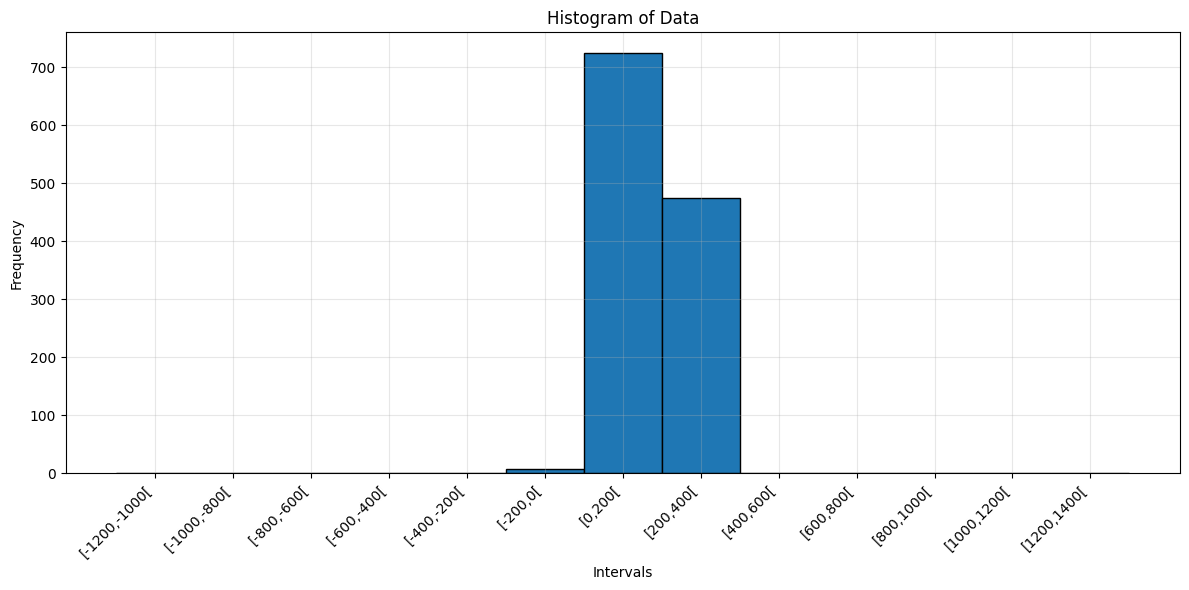

In [6]:
print("length of gain list : ",len(gain_list))
gain_list = np.array(gain_list)
print(gain_list)
# Calculate basic statistics
mean = np.mean(gain_list)
median = np.median(gain_list)
std_dev = np.std(gain_list)

# Calculate percentiles
percentiles = np.percentile(gain_list, [25, 50, 75])

# Print results
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {std_dev}")
print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile (Median): {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")

# Create the histogram
bin_edges = np.arange(-1200, 1401, 200)
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(gain_list, bins=bin_edges, edgecolor='black')

# Set custom x-axis labels
labels = [f'[{bins[i]:.0f},{bins[i+1]:.0f}[' for i in range(len(bins)-1)]
plt.xticks(bins[:-1] + 100, labels, rotation=45, ha='right')

plt.title('Histogram of Data')
plt.xlabel('Intervals')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

STOCK PICKING :

In [ ]:




def get_current_other_expenses(other_expenses_dict,stock):
    today = pd.Timestamp.now().date()
    return get_recent_other_expenses(other_expenses_dict, stock, today)

def get_current_50W_SMA(stock,hist_weeks):

    today = pd.Timestamp.now().tz_localize(None)
    end_date = today + pd.DateOffset(days=2)
    start_date = end_date - pd.DateOffset(weeks=60)

    hist_weeks = hist_weeks.copy()
    hist_weeks.index = hist_weeks.index.tz_localize(None)

    if hist_weeks.empty:
        return None, None
    hist_weeks= hist_weeks.copy()

    stock_data = hist_weeks.xs(stock, axis=1, level=1)

    stock_data['SMA_50'] = stock_data['Close'].rolling(window=50, min_periods=1).mean()
    stock_data['SMA_50']= stock_data['SMA_50'].round().astype(int)
    closest_date = pd.Timestamp(today.date())

    max_offset= 4
    while max_offset >0 and closest_date not in stock_data.index and closest_date > stock_data.index[0]:
        closest_date -= dt.timedelta(days=1)
        max_offset -=1

    if max_offset<0:
        return None,None

    sma_value = stock_data.loc[closest_date, 'SMA_50'] if closest_date in stock_data.index else None
    return sma_value, stock_data['SMA_50']

def get_current_10d_SMA(stock):

    today = pd.Timestamp.now()
    end_date = today + pd.DateOffset(days=2)
    start_date = end_date - pd.DateOffset(days=20)

    hist_weeks = yf.download(stock, start=start_date.strftime('%Y-%m-%d'), end=end_date, interval='1d')
    if hist_weeks.empty:
        return None, None
    hist_weeks = hist_weeks.copy()

    hist_weeks['SMA_10d'] = hist_weeks['Close'].rolling(window=10, min_periods=1).mean()
    hist_weeks['SMA_10d'] = hist_weeks['SMA_10d'].round().astype(int)
    closest_date = pd.Timestamp(today.date())

    max_offset= 2
    while max_offset >0 and closest_date not in hist_weeks.index and closest_date > hist_weeks.index[0]:
        closest_date -= dt.timedelta(days=1)
        max_offset -=1

    if max_offset<0:
        return None,None

    sma_value = hist_weeks.loc[closest_date, 'SMA_10d'] if closest_date in hist_weeks.index else None
    return sma_value, hist_weeks['SMA_10d']

stocks_df = pd.read_csv('sp_500_stocks.csv')
stocks = stocks_df['Ticker'].tolist()
stocks = random.sample(stocks, 240)
other_expenses_dict = {}

for stock in stocks:
    otherexp = get_OtherExpenses(stock)
    other_expenses_dict[stock]=otherexp

RATIO_LOWER_BOUND = 0
RATIO_UPPER_BOUND = 0.25
print("buy these stocks now")
today = pd.Timestamp.now()
today_floor = pd.Timestamp(today).floor('D')
end_date = today + pd.DateOffset(days=2)
start_date_days = end_date - pd.DateOffset(days=20)
start_date_weeks = end_date - pd.DateOffset(weeks=60)
hist_days = yf.download(stocks, start=start_date_days.strftime('%Y-%m-%d'), end=end_date, interval='1d')
hist_weeks = yf.download(stocks, start=start_date_weeks.strftime('%Y-%m-%d'), end=end_date, interval='1wk')

data_5yr = yf.download(stocks, period="5y")
#data_5yr = yf.download(stocks, period="5y")
for stock in stocks:
  #print(stock)
  revenues = get_revenues(stock)
  if revenues is None:
    continue
  if not isinstance(revenues.index, pd.DatetimeIndex):
    revenues.index = pd.to_datetime(revenues.index)
  revenues = revenues.sort_index(ascending=True)
  # get most recent revenue before today
  recent_revenues = revenues.loc[:today]
  recent_revenue_date = None
  recent_revenue_value = None
  if not recent_revenues.empty:
      recent_revenue_date = recent_revenues.index[-1]
      recent_revenue_value = recent_revenues.iloc[-1]
      if recent_revenue_date < today - timedelta(days=365):
          continue
      market_cap = get_today_market_cap(stock,fmp_api_key)
      if recent_revenue_value is not None and market_cap is not None:
        ratio = market_cap/recent_revenue_value
        if RATIO_LOWER_BOUND <= ratio <= RATIO_UPPER_BOUND:
            current_price = None
            stock_data_today = hist_days.xs(stock, axis=1, level=1)
            stock_data_today.index = stock_data_today.index.tz_localize(None)
            closest_date = pd.Timestamp(today.date())

            current_price = stock_data_today.loc[closest_date, 'Close'] if closest_date in stock_data_today.index else None
            current_SMA50Y,_ = get_current_50W_SMA(stock,hist_weeks)
            current_SMA10D,_ = get_current_10d_SMA(stock)
            _,current_other_exp_value = get_current_other_expenses(other_expenses_dict,stock)

            prediction, buy_probability = predict_buy(
                date=today,
                symbol=stock,
                price=current_price,
                ratio=ratio,
                SMA_50=current_SMA50Y,
                SMA_10d=current_SMA10D,
                other_expense=current_other_exp_value
            )
            if prediction is None or prediction ==1:
              print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
              print(f"stock {stock}, current price : {current_price} current_SMA50Y : {current_SMA50Y} , current_SMA10D : {current_SMA10D}, current_other_exp_value = {current_other_exp_value}")
              print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
              print(stock)
            else:
              print(f"dont buy {stock} even though it looks good")

[                       0%                       ]

buy these stocks now


[*********************100%***********************]  240 of 240 completed
ERROR:yfinance:
13 Failed downloads:
ERROR:yfinance:['FBHS', 'DRE', 'FRC', 'FLIR', 'PBCT', 'INFO', 'HFC', 'CERN', 'MXIM', 'PEAK', 'CTL', 'BLL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:['SIVB']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%***********************]  240 of 240 completed
ERROR:yfinance:
13 Failed downloads:
ERROR:yfinance:['FBHS', 'DRE', 'FRC', 'FLIR', 'PBCT', 'INFO', 'HFC', 'CERN', 'MXIM', 'PEAK', 'CTL', 'BLL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:['SIVB']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%***********************]  240 of 240 completed
ERROR:yfinance:
15 Failed downloads:
ERROR:yfinance:['FISV', 'MBLY']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
stock CAH, current price : 109.55000305175781 current_SMA50Y : 104 , current_SMA10D : 111, current_other_exp_value = -510000.0
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
CAH


<ipython-input-41-ce9bf6791d34>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SMA_50'] = stock_data['Close'].rolling(window=50, min_periods=1).mean()
<ipython-input-41-ce9bf6791d34>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SMA_50']= stock_data['SMA_50'].round().astype(int)
[*********************100%***********************]  1 of 1 completed


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
stock AAP, current price : 40.5099983215332 current_SMA50Y : 63 , current_SMA10D : 41, current_other_exp_value = -880550.0
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
AAP


<ipython-input-41-ce9bf6791d34>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SMA_50'] = stock_data['Close'].rolling(window=50, min_periods=1).mean()
<ipython-input-41-ce9bf6791d34>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SMA_50']= stock_data['SMA_50'].round().astype(int)
[*********************100%***********************]  1 of 1 completed


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
stock MCK, current price : 481.75750732421875 current_SMA50Y : 522 , current_SMA10D : 503, current_other_exp_value = -1340000.0
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
MCK


<ipython-input-41-ce9bf6791d34>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SMA_50'] = stock_data['Close'].rolling(window=50, min_periods=1).mean()
<ipython-input-41-ce9bf6791d34>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SMA_50']= stock_data['SMA_50'].round().astype(int)
[*********************100%***********************]  1 of 1 completed


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
stock CVS, current price : 58.520198822021484 current_SMA50Y : 67 , current_SMA10D : 58, current_other_exp_value = -26580000.0
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
CVS


TESTING ON HISTORICAL DATA

In [ ]:
stocks_df = pd.read_csv('sp_500_stocks.csv')
stocks = stocks_df['Ticker'].tolist()
stocks = random.sample(stocks, 210)
data_5yr = yf.download(stocks, period="5y")
min_ratio = 2
stock_used = set()
prices_after_X_years =[]


best_stocks_list=[]
counter = 0;
historical_market_cap_startdate = datetime.strptime('28/08/2019', '%d/%m/%Y')
historical_market_cap_enddate = datetime.strptime('28/08/2024', '%d/%m/%Y')

for stock in stocks:
  counter+=1;
  if stock not in data_5yr['Close']:
      continue
  stock_data_5y = data_5yr['Close'][stock].tz_localize(None)
  print("stock : ",stock)
  revenues = get_revenues(stock)
  if revenues is None:
    continue
  if not isinstance(revenues.index, pd.DatetimeIndex):
      revenues.index = pd.to_datetime(revenues.index)
  revenues = revenues.sort_index(ascending=True)
  historical_market_cap = get_fmp_market_cap(stock,historical_market_cap_startdate, historical_market_cap_enddate, fmp_api_key)
  print(counter)
  for i in range(0,len(revenues)-1):
    if pd.isna(revenues.iloc[i]):
      continue
    start_date = revenues.index[i] + timedelta(days=2)
    end_date = revenues.index[i+1] - timedelta(days=2)
    #historical_market_cap = get_fmp_market_cap(stock, start_date, end_date, fmp_api_key)
    date_range = pd.date_range(start=start_date, end=end_date)
    print(f"date range : [{start_date},{end_date}]")
    for date in date_range:
      date = date.date()
      if date.year == 2020:
          continue  # Skip corona year
      if date in historical_market_cap:
        ratio = historical_market_cap[date]/revenues.iloc[i]
        if ratio <min_ratio:
          price_at_date = get_stock_price(stock, date)
          if price_at_date is not None:
              date_after_1Y = date + pd.DateOffset(years=1)
              if date + timedelta(days=365) < pd.Timestamp.today().date():
                #price_after_one_year = get_stock_price(stock, date + timedelta(days=365))
                last_price_after_1Y = stock_data_5y[date:date_after_1Y].iloc[-1]
                max_price_within_one_year = stock_data_5y[date:date_after_1Y].max()
                if max_price_within_one_year is not None and price_at_date is not None:
                      if stock not in stock_used:
                        stock_used.add(stock)
                      percentage_increase = (max_price_within_one_year - price_at_date) / price_at_date * 100
                      best_stocks_list.append({
                                  'Stock': stock,
                                  'Date of Condition': date,
                                  'price at date d': price_at_date,
                                  'percentage increase': percentage_increase,
                                  'ratio': ratio
                              })
                      if last_price_after_1Y is not None:
                        prices_after_X_years.append({
                            'Stock': stock,
                            'Date of Condition': date,
                            'date_after_1Y':date_after_1Y,
                            'Last Price after 1Y': last_price_after_1Y,
                            'percentage diff': (last_price_after_1Y-price_at_date)/price_at_date*100,
                            'ratio': ratio
                        })



#print(best_stocks_df)

[*********************100%***********************]  210 of 210 completed
ERROR:yfinance:
16 Failed downloads:
ERROR:yfinance:['ANTM', 'FRC', 'ATVI', 'PKI', 'COG', 'ABC', 'PBCT', 'DISCK', 'DISH', 'VIAC', 'FLT', 'FBHS', 'NLOK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')
ERROR:yfinance:['MBLY', 'FISV']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']")
ERROR:yfinance:['SIVB']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d']")


stock :  FTV
1
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00:00,2022-12-29 00:00:00]
date range : [2023-01-02 00:00:00,2023-12-29 00:00:00]
stock :  DTE
2
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00:00,2022-12-29 00:00:00]
date range : [2023-01-02 00:00:00,2023-12-29 00:00:00]
stock :  LLY
3
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00:00,2022-12-29 00:00:00]
date range : [2023-01-02 00:00:00,2023-12-29 00:00:00]
stock :  BLK
4
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00:00,2022-12-29 00:00:00]
date range : [2023-01-02 00:00:00,2023-12-29 00:00:00]
stock :  MET
5
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00:00,2022-12-29 00:00:00]
date range : [2023-01-02 00:00:00,2023-12-29 00:00:00]
stock :  FMC
6
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00

ERROR:yfinance:$SYY: possibly delisted; no price data found  (1d 2022-07-15 -> 2022-07-16)


date range : [2023-07-02 00:00:00,2024-06-28 00:00:00]
stock :  SEE
35
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00:00,2022-12-29 00:00:00]
date range : [2023-01-02 00:00:00,2023-12-29 00:00:00]
stock :  BDX
36
date range : [2020-10-02 00:00:00,2021-09-28 00:00:00]
date range : [2021-10-02 00:00:00,2022-09-28 00:00:00]
date range : [2022-10-02 00:00:00,2023-09-28 00:00:00]
stock :  INCY
37
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00:00,2022-12-29 00:00:00]
date range : [2023-01-02 00:00:00,2023-12-29 00:00:00]
stock :  ESS
38
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00:00,2022-12-29 00:00:00]
date range : [2023-01-02 00:00:00,2023-12-29 00:00:00]
stock :  LEG
39
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00:00,2022-12-29 00:00:00]
date range : [2023-01-02 00:00:00,2023-12-29 00:00:00]
stock :  TDG
40
date range : [2020-10-0

ERROR:yfinance:$GD: possibly delisted; no price data found  (1d 2023-08-23 -> 2023-08-24)


stock :  FISV
stock :  NTAP
51
date range : [2021-05-02 00:00:00,2022-04-28 00:00:00]
date range : [2022-05-02 00:00:00,2023-04-28 00:00:00]
date range : [2023-05-02 00:00:00,2024-04-28 00:00:00]
stock :  WDC
52
date range : [2021-07-02 00:00:00,2022-06-28 00:00:00]
date range : [2022-07-02 00:00:00,2023-06-28 00:00:00]
date range : [2023-07-02 00:00:00,2024-06-28 00:00:00]
stock :  KSS
53
date range : [2021-02-02 00:00:00,2022-01-29 00:00:00]
date range : [2022-02-02 00:00:00,2023-01-29 00:00:00]
date range : [2023-02-02 00:00:00,2024-01-29 00:00:00]
stock :  ADBE
54
date range : [2020-12-02 00:00:00,2021-11-28 00:00:00]
date range : [2021-12-02 00:00:00,2022-11-28 00:00:00]
date range : [2022-12-02 00:00:00,2023-11-28 00:00:00]
stock :  GS
55
date range : [2021-01-02 00:00:00,2021-12-29 00:00:00]
date range : [2022-01-02 00:00:00,2022-12-29 00:00:00]
date range : [2023-01-02 00:00:00,2023-12-29 00:00:00]
stock :  STX
56
date range : [2021-07-02 00:00:00,2022-06-28 00:00:00]
date rang

In [ ]:
best_stocks_df = pd.DataFrame(best_stocks_list)

In [ ]:
pd.set_option('display.max_rows', None)
best_stocks_df = best_stocks_df.sort_values(by="percentage increase", ascending=True)

# Print the sorted DataFrame
print(f"there are {len(stock_used)} distinct stocks in this list")
#print(best_stocks_df)

there are 130 distinct stocks in this list


<ipython-input-6-9d0988a132a4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_by_ration['Date of Condition'] = pd.to_datetime(df_filtered_by_ration['Date of Condition'])
<ipython-input-6-9d0988a132a4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_by_ration['Month'] = df_filtered_by_ration['Date of Condition'].dt.to_period('M')
<ipython-input-6-9d0988a132a4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

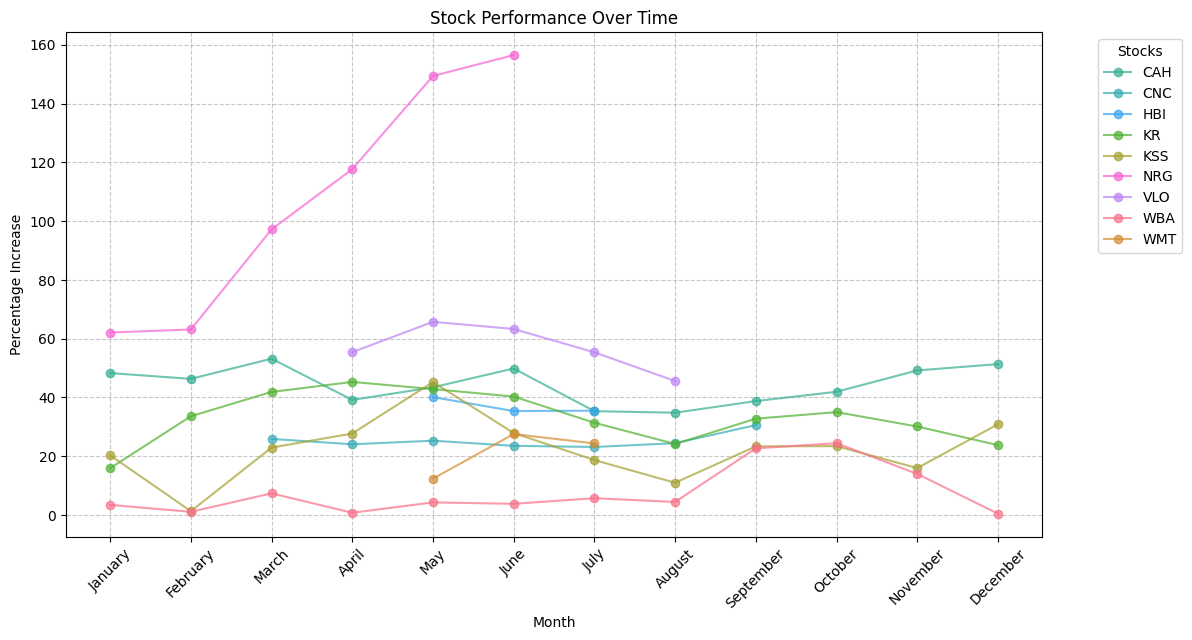

In [ ]:
# Filter the DataFrame based on the 'ratio' column
df_filtered_by_ration = best_stocks_df[(best_stocks_df['ratio'] >= 0) & (best_stocks_df['ratio'] <= 0.25)]

# Convert the 'Date of Condition' to datetime format
df_filtered_by_ration['Date of Condition'] = pd.to_datetime(df_filtered_by_ration['Date of Condition'])

# Extract the month (in 'Period' format) from the 'Date of Condition'
df_filtered_by_ration['Month'] = df_filtered_by_ration['Date of Condition'].dt.to_period('M')

# Get unique stocks
unique_stocks = df_filtered_by_ration['Stock'].unique()

# Create a color palette with a unique color for each stock
color_palette = sns.color_palette("husl", n_colors=len(unique_stocks))
color_dict = dict(zip(unique_stocks, color_palette))

# Create the plot
plt.figure(figsize=(12, 6))

# Extract the month name (without the year) from the 'Month' column
df_filtered_by_ration['Month_Name'] = df_filtered_by_ration['Month'].dt.strftime('%B')

# Ensure months are in the correct order
month_order = ['January', 'February', 'March', 'April',
               'May', 'June', 'July', 'August',
               'September', 'October', 'November', 'December']
df_filtered_by_ration['Month_Name'] = pd.Categorical(df_filtered_by_ration['Month_Name'],
                                                     categories=month_order, ordered=True)

# Group by Stock and Month_Name, then calculate the mean percentage increase
average_monthly_data = df_filtered_by_ration.groupby(['Stock', 'Month_Name'])['percentage increase'].mean().reset_index()

# Now, iterate through unique stocks and plot the data
unique_stocks = average_monthly_data['Stock'].unique()

for stock in unique_stocks:
    stock_data = average_monthly_data[average_monthly_data['Stock'] == stock]
    plt.plot(stock_data['Month_Name'], stock_data['percentage increase'],
             label=stock, color=color_dict[stock], marker='o', alpha=0.7)

plt.xlabel('Month')
plt.ylabel('Percentage Increase')
plt.title('Stock Performance Over Time')
plt.legend(title='Stocks', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

<ipython-input-7-beaa19f9f94f>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = best_stocks_df.groupby('ratio_range')


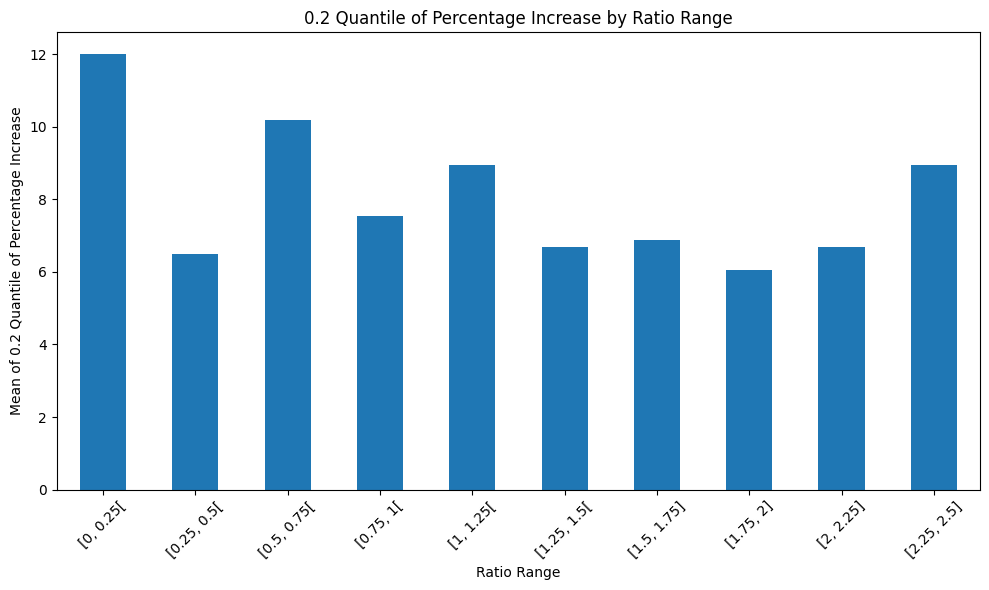

In [ ]:
import matplotlib.pyplot as plt
best_stocks_df.set_index('Stock', inplace=True)
best_stocks_df['percentage increase'] = pd.to_numeric(best_stocks_df['percentage increase'], errors='coerce')
percentage_increase = best_stocks_df['percentage increase']

bins = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
labels = ['[0, 0.25[', '[0.25, 0.5[', '[0.5, 0.75[', '[0.75, 1[', '[1, 1.25[', '[1.25, 1.5[', '[1.5, 1.75]','[1.75, 2]','[2, 2.25]','[2.25, 2.5]']

best_stocks_df['ratio_range'] = pd.cut(best_stocks_df['ratio'], bins=bins, labels=labels, include_lowest=True)

grouped = best_stocks_df.groupby('ratio_range')
result = grouped.apply(lambda x: x['percentage increase'].quantile(0.2)) #.mean()

# Create the histogram
plt.figure(figsize=(10, 6))
result.plot(kind='bar')
plt.title('0.2 Quantile of Percentage Increase by Ratio Range')
plt.xlabel('Ratio Range')
plt.ylabel('Mean of 0.2 Quantile of Percentage Increase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PERCENTAGE DIFF IF WE DONT PUT A SELL LIMIT

In [ ]:
last_prices_df = pd.DataFrame(prices_after_X_years)
last_prices_df = last_prices_df.set_index('Stock')
last_prices_df_filtered_ratio = last_prices_df[(last_prices_df['ratio'] >= 0) & (last_prices_df['ratio'] <= 0.25)]

last_prices_df_filtered_ratio['percentage diff'] = pd.to_numeric(last_prices_df_filtered_ratio['percentage diff'], errors='coerce')
percentage_diff = last_prices_df_filtered_ratio['percentage diff']


<ipython-input-8-26dccdfd1b05>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_prices_df_filtered_ratio['percentage diff'] = pd.to_numeric(last_prices_df_filtered_ratio['percentage diff'], errors='coerce')


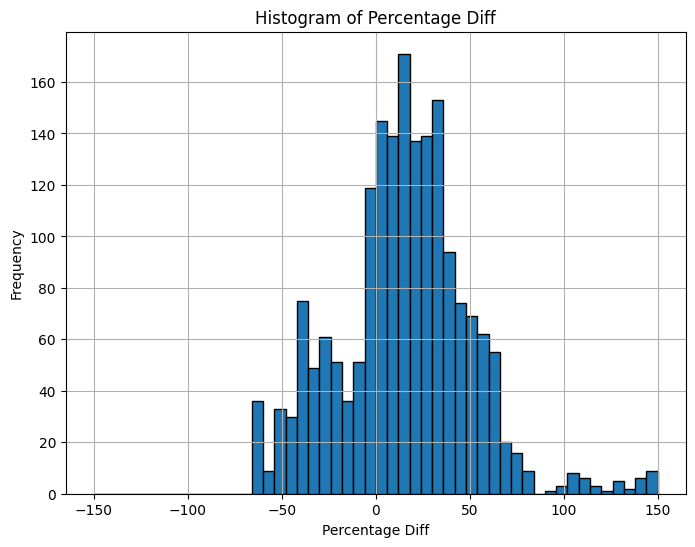

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(percentage_diff, bins=50, edgecolor='black', range=(-150, 150))
plt.title('Histogram of Percentage Diff')
plt.xlabel('Percentage Diff')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
def calculate_percentage_diff(percentage_diff, limit_order_percent):
    filtered_diff = percentage_diff[percentage_diff < limit_order_percent]
    mean_value = filtered_diff.mean()
    median_value = filtered_diff.median()
    return mean_value, median_value

thresholds = list(range(5, 155, 2))

# Store results
results = []

for threshold in thresholds:
    filtered_diff = percentage_diff[percentage_diff < threshold]
    mean_value = filtered_diff.mean()
    median_value = filtered_diff.median()
    results.append((threshold, mean_value, median_value))

percentage_diff_mean_df = pd.DataFrame(results, columns=['limit order in %', 'Mean Percentage Diff after Maturity', 'Median Percentage Diff'])
print(percentage_diff_mean_df)

    limit order in %  Mean Percentage Diff after Maturity  \
0                  5                           -20.452297   
1                  7                           -19.184970   
2                  9                           -18.158906   
3                 11                           -16.250423   
4                 13                           -14.123788   
5                 15                           -12.387721   
6                 17                           -10.757135   
7                 19                            -8.931124   
8                 21                            -7.735525   
9                 23                            -6.729056   
10                25                            -5.722840   
11                27                            -4.245418   
12                29                            -3.048728   
13                31                            -2.235482   
14                33                            -1.068775   
15                35    

In [ ]:
mean_value_of_percent_after2Y = percentage_diff.mean()
median_value_of_percent_after2Y = percentage_diff.median()
print("if you buy a stock satisfying the condition and you dont put a sell limit, then after 2 years the average percentage diff is : ",mean_value_of_percent_after2Y)
print("median_value_of_percent_after2Y: ",median_value_of_percent_after2Y)

if you buy a stock satisfying the condition and you dont put a sell limit, then after 2 years the average percentage diff is :  15.417310121843284
median_value_of_percent_after2Y:  15.746414535727954


In [ ]:
def calculate_percentiles_for_ranges(best_stocks_df,last_prices_df, step=0.25, max_ratio=2):
    ratio_ranges = []
    for i in range(0, int(max_ratio / step) + 1):
        start = i * step
        end = (i + 1) * step
        ratio_ranges.append((start, end))

    for lower_bound, upper_bound in ratio_ranges:
        # Filter the DataFrame based on the current ratio range
        filtered_df = best_stocks_df[(best_stocks_df['ratio'] >= lower_bound) & (best_stocks_df['ratio'] <= upper_bound)]

        last_prices_df_filtered_ratio = last_prices_df[(last_prices_df['ratio'] >= lower_bound) & (last_prices_df['ratio'] <= upper_bound)]
        last_prices_df_filtered_ratio['percentage diff'] = pd.to_numeric(last_prices_df_filtered_ratio['percentage diff'], errors='coerce')
        percentage_diff = last_prices_df_filtered_ratio['percentage diff']


        if not filtered_df.empty:
            percentage_increase = filtered_df['percentage increase']

            # Calculate percentiles
            percentile_60 = percentage_increase.quantile(0.6)
            percentile_50 = percentage_increase.quantile(0.5)
            percentile_40 = percentage_increase.quantile(0.4)
            percentile_30 = percentage_increase.quantile(0.3)
            percentile_20 = percentage_increase.quantile(0.2)
            limit_order_20 = calculate_percentage_diff(percentage_diff, percentile_20)[0]
            limit_order_30 = calculate_percentage_diff(percentage_diff, percentile_30)[0]
            limit_order_40 = calculate_percentage_diff(percentage_diff, percentile_40)[0]
            limit_order_50 = calculate_percentage_diff(percentage_diff, percentile_50)[0]
            limit_order_60 = calculate_percentage_diff(percentage_diff, percentile_60)[0]
            # Print the results
            print(f"Ratio range {lower_bound} to {upper_bound}:")
            print(f"0.4 prob to reach {percentile_60}% and 0.6 {limit_order_60} so expected return : {0.4*percentile_60+0.6*limit_order_60}%")
            print(f"0.5 prob to reach {percentile_50}% and 0.5 {limit_order_50} so expected return : {0.5*percentile_50+0.5*limit_order_50}%")
            print(f"0.6 prob to reach {percentile_40}% and 0.4 {limit_order_40} so expected return : {0.6*percentile_40+0.4*limit_order_40}%")
            print(f"0.7 prob to reach {percentile_30}% and 0.3 {limit_order_30} so expected return : {0.7*percentile_30+0.3*limit_order_30}%")
            print(f"0.8 prob to reach {percentile_20}% and 0.2 {limit_order_20} so expected return : {0.8*percentile_20+0.2*limit_order_20}%")
            print("\n")
        else:
            print(f"No data for ratio range {lower_bound} to {upper_bound}.\n")
calculate_percentiles_for_ranges(best_stocks_df,last_prices_df)

Ratio range 0.0 to 0.25:
0.4 prob to reach 37.704905487471436% and 0.6 1.9381275415507038 so expected return : 16.244838719919%
0.5 prob to reach 30.76603778561485% and 0.5 -2.286589991399062 so expected return : 14.239723897107893%
0.6 prob to reach 25.075328419398694% and 0.4 -5.643724787544282 so expected return : 12.787707136621503%
0.7 prob to reach 19.31898681342275% and 0.3 -8.717249975454775 so expected return : 10.908115776759491%
0.8 prob to reach 12.006257915504651% and 0.2 -15.021054795933411 so expected return : 6.600795373217039%


Ratio range 0.25 to 0.5:
0.4 prob to reach 25.68111796222085% and 0.6 -10.1864540057677 so expected return : 4.16057478142772%
0.5 prob to reach 20.082821580761603% and 0.5 -11.641353343904472 so expected return : 4.220734118428566%
0.6 prob to reach 15.745413417170843% and 0.4 -13.288864344448418 so expected return : 4.131702312523138%
0.7 prob to reach 10.96739323062399% and 0.3 -15.624956676963128 so expected return : 2.9896882583478552%
0.8

<ipython-input-12-3879f0f25288>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_prices_df_filtered_ratio['percentage diff'] = pd.to_numeric(last_prices_df_filtered_ratio['percentage diff'], errors='coerce')
<ipython-input-12-3879f0f25288>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_prices_df_filtered_ratio['percentage diff'] = pd.to_numeric(last_prices_df_filtered_ratio['percentage diff'], errors='coerce')
<ipython-input-12-3879f0f25288>:13: SettingWithCopyWarning: 
A value is trying to be

In [ ]:


print("analytics on percentage increase : ")
best_stocks_df_filtered_ration = best_stocks_df[(best_stocks_df['ratio'] >= 0) & (best_stocks_df['ratio'] <= 0.25)]


percentage_increase = best_stocks_df_filtered_ration['percentage increase']


mean_value = percentage_increase.mean()
max_value = percentage_increase.max()
min_value = percentage_increase.min()

median_value = percentage_increase.median()
percentile_95 = percentage_increase.quantile(0.95)
percentile_90 = percentage_increase.quantile(0.9)
percentile_80 = percentage_increase.quantile(0.8)
percentile_70 = percentage_increase.quantile(0.7)
percentile_60 = percentage_increase.quantile(0.6)
percentile_40 = percentage_increase.quantile(0.4)
percentile_30 = percentage_increase.quantile(0.3)
percentile_20 = percentage_increase.quantile(0.2)
percentile_10 = percentage_increase.quantile(0.1)
percentile_05 = percentage_increase.quantile(0.05)

#five_minimal_values = percentage_increase.nsmallest(5)


print(f"Mean: {mean_value}")
print(f"Max: {max_value}")
print(f"Min: {min_value}")
print(f"Median: {median_value}")
print(f"90th Percentile: {percentile_90}")
print(f"80th Percentile: {percentile_80} -> 20% of chance to reach {percentile_80}% gain")
print(f"70th Percentile: {percentile_70}")
print(f"60th Percentile: {percentile_60}")
print(f"50th Percentile: {median_value}")
print(f"40th Percentile: {percentile_40}")
print(f"30th Percentile: {percentile_30}")
print(f"20th Percentile: {percentile_20} -> 80% of chance to reach {percentile_20}% gain ")
print(f"10th Percentile: {percentile_10} -> 90% of chance to reach {percentile_10}% gain")
print(f"10th Percentile: {percentile_05} -> 95% of chance to reach {percentile_05}% gain")
#print(f"10 Minimal Values: \n{five_minimal_values}")

analytics on percentage increase : 
Mean: 45.67083910695241
Max: 283.82748314554175
Min: 0.0
Median: 37.20029450640346
90th Percentile: 78.67542527542346
80th Percentile: 63.30658707246825 -> 20% of chance to reach 63.30658707246825% gain
70th Percentile: 53.721735056378016
60th Percentile: 45.199248183291616
50th Percentile: 37.20029450640346
40th Percentile: 29.446305346896146
30th Percentile: 23.998735779727145
20th Percentile: 17.16911642453207 -> 80% of chance to reach 17.16911642453207% gain 
10th Percentile: 8.351001290378628 -> 90% of chance to reach 8.351001290378628% gain
10th Percentile: 2.8459247580455442 -> 95% of chance to reach 2.8459247580455442% gain


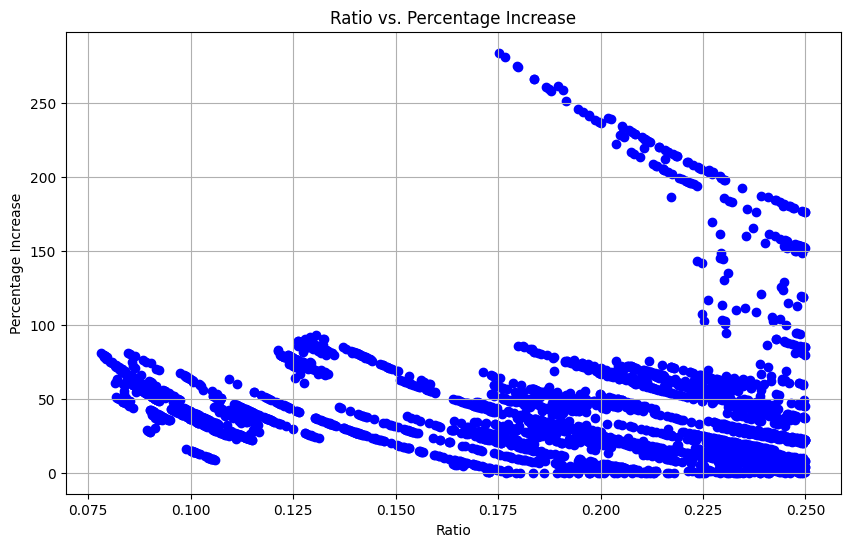

In [ ]:
import matplotlib.pyplot as plt

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.scatter(best_stocks_df_filtered_ration['ratio'], best_stocks_df_filtered_ration['percentage increase'], color='blue')

# Adding title and labels
plt.title('Ratio vs. Percentage Increase')
plt.xlabel('Ratio')
plt.ylabel('Percentage Increase')

# Display the graph
plt.grid(True)
plt.show()

[nan, 56.254165906523795, 25.41076514402337, 28.13481943678984, 24.928553041531874, 26.858544381984313, 28.708124017095514, 28.32026682963214, 24.1789679810159, 19.897098472126, 19.9585603879516, 18.044796379614592, 18.34091219355573, 20.332801238999544, 25.81399321848693]


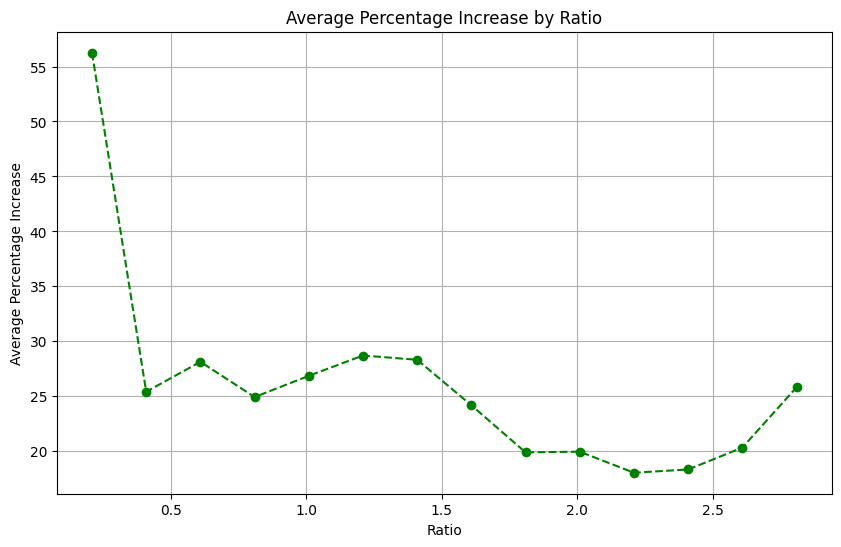

In [ ]:
import numpy as np

# Define the ratios to calculate the average percentage increase
ratios = np.arange(0.01, 3, 0.2)
averages = []

# Calculate the average percentage increase for each ratio range
for ratio in ratios:
    lower_bound = ratio - 0.05
    upper_bound = ratio + 0.05
    mask = (best_stocks_df['ratio'] >= lower_bound) & (best_stocks_df['ratio'] <= upper_bound)
    avg_percentage_increase = best_stocks_df.loc[mask, 'percentage increase'].mean()
    averages.append(avg_percentage_increase)

print(averages)
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(ratios, averages, marker='o', color='green', linestyle='--')

# Adding title and labels
plt.title('Average Percentage Increase by Ratio')
plt.xlabel('Ratio')
plt.ylabel('Average Percentage Increase')

# Display the graph
plt.grid(True)
plt.show()